In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import random
import math
import matplotlib.pyplot as plt

In [15]:
x = np.random.normal(size=(10000,4))
error = np.random.normal(size=(10000,1))
b = np.random.uniform(size=(4,1))

### in order to avoid Perfect Separation, we need to add some noise
y = x@b + error

# y = list(map(lambda x: 1 if x > 0 else 0, y))

# binary
# y = np.array([0 if x <0 else 1  for x in y])

## 3 classes
y = np.array([0 if x < -1 else 1 if x < 1 else 2 for x in y])

([array([6.000e+00, 7.600e+01, 5.220e+02, 1.837e+03, 3.176e+03, 2.805e+03,
         1.224e+03, 3.160e+02, 3.600e+01, 2.000e+00]),
  array([4.000e+00, 7.500e+01, 5.060e+02, 1.785e+03, 3.153e+03, 2.832e+03,
         1.323e+03, 2.940e+02, 2.600e+01, 2.000e+00]),
  array([8.000e+00, 8.800e+01, 5.060e+02, 1.894e+03, 3.111e+03, 2.801e+03,
         1.264e+03, 2.930e+02, 3.400e+01, 1.000e+00]),
  array([9.000e+00, 9.100e+01, 5.080e+02, 1.855e+03, 3.116e+03, 2.818e+03,
         1.294e+03, 2.750e+02, 3.200e+01, 2.000e+00])],
 array([-4.10035173, -3.25181386, -2.40327599, -1.55473811, -0.70620024,
         0.14233763,  0.9908755 ,  1.83941337,  2.68795124,  3.53648911,
         4.38502698]),
 <a list of 4 Lists of Patches objects>)

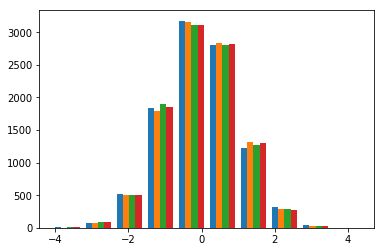

In [16]:
plt.hist(x)

In [17]:
class data_generate_process:
    def __init__(self, x, y):
        self.x = x
        self.y = y    
        
    def split(self, rate = 0.7, random_state = 1024, scale = False):
        ## Feature scaling is used to normalize the range of independent variables or features of data
        if scale:
            self.x = (self.x - np.mean(self.x))/x.std()
        
        n = len(self.y)
        np.random.seed(random_state)
        
        ##randomly spilte data into 70% train and 30% test
        index = list(range(n))
        np.random.shuffle(index)
        train = index[:int(rate*n)]
        test = index[int(rate*n):]
        
        self.train_x = self.x[train]
        self.test_x = self.x[test]
        self.train_y = self.y[train]
        self.test_y = self.y[test]
        
        return self.train_x, self.test_x, self.train_y, self.test_y
    
train_x, test_x, train_y, test_y = data_generate_process(x, y ).split()

In [18]:
class model:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def lda(self, x = None, y = None):
        if x is None:
            x = self.x
        if y is None:
            y = self.y
            
        ## vector of k classes in an ascending order
        groups = np.unique(y)
        self.groups = groups
        
        ##create N by k (classes) matrix
        likehood = np.zeros((len(x), len(groups))) 
        
        means = {}
        covariances = {}
        indexs = {}
        
        for group in groups:
            ##get the index of all the x that belong to k classes
            index = np.where(y == groups[group])[0]
            indexs[group] = index
            
            means[group] = np.mean(x[index],axis = 0)
            
            covariances[group] = np.cov(x.T)
            
        self.index = indexs
        self.mean = means
        self.covariance = covariances 

    def lda_predict(self, x, mean = None, covariance = None):
        if covariance is None:
            covariance = self.covariance

        if mean is None:
            mean = self.mean
            
        
        ##create N by k (classes) matrix
        likehood = np.zeros((len(x), len(self.groups)))
#         print(likehood.shape)
        for group in self.groups:
            mean = self.mean[group]
            covariance = self.covariance[group]
            covariance_inv = np.linalg.inv(covariance)
            ## calcuate how many points belong to kth class
            ## that's the probably
            points = len(self.index[group])
            
            probablity = x@covariance_inv@mean - 0.5*mean.T@covariance_inv@mean +np.log(points)
                                
            likehood[:,group] = probablity
            
        ##get the index of max likehood for each observations
            self.labels = likehood.argmax(axis = 1)
        return self.labels
            
    def qda(self, x = None, y = None):
        if x is None:
            x = self.x
        if y is None:
            y = self.y
            
        ## vector of k classes in an ascending order
        groups = np.unique(y)
        self.groups = groups
        
        ##create N by k (classes) matrix
        likehood = np.zeros((len(x), len(groups)))  
        
        means = {}
        covariances = {}
        indexs = {}
        
        for group in groups:
            ##get the index of all the x that belong to k classes
            index = np.where(y == groups[group])[0]
            indexs[group] = index
            
             ## calcuate mean & covariance matrix of all the x that belong to k classes
            means[group] = np.mean(x[index],axis = 0)
            
            covariances[group] = np.cov(x[index].T)
        
        self.index = indexs
        self.mean = means
        self.covariance = covariances
 
    def qda_predict(self, x, mean = None, covariance = None):
        if covariance is None:
            covariance = self.covariance

        if mean is None:
            mean = self.mean
            
        
        ##create N by k (classes) matrix
        likehood = np.zeros((len(x), len(self.groups)))
#         print(likehood.shape)
        for group in self.groups:
            mean = self.mean[group]
            covariance = self.covariance[group]
            
            ## calcuate how many points belong to kth class
            ## that's the probably
            points = len(self.index[group])
            
            shift = x - mean
            ## create a diag matrix of covariance with all 0 expcet the diagonal
            scale = np.diagflat(np.diag(covariance))
            scale_inv = np.linalg.inv(scale)
            det = np.linalg.det(scale)
            ## log(points/N), N can't be obmitted
#             probablity = np.log(points)- 0.5*np.log(np.linalg.det(scale))- 0.5*np.diag(shift@np.linalg.inv(scale)@shift.T)
            probablity = np.log(points) - 0.5*np.log(det ) - 0.5*np.diag(shift@scale_inv@shift.T)
                                
            likehood[:,group] = probablity
            
        ##get the index of max likehood for each observations
            self.labels = likehood.argmax(axis = 1)
        return self.labels

    def confusion_matirx(self, test, pred):
        groups = np.unique(test_y)
        
        index_true = {i:[] for i in groups}

        ## index of each class of true labels
        for index, label in enumerate(test_y):
            index_true[label].append(index)

        counts = []
        ## groupby classes of true labels, count the numbers for each class in predict
        for group in groups:
            count = {i:0 for i in groups}
            for label in pred[index_true[group]]:
                count[label] += 1
            counts.append(count)

        matirx = pd.DataFrame(counts)
        columns_names =  ['predict '+str(group) for group in groups]
        matirx.columns = columns_names
        
        self.matirx = matirx
        return  self.matirx
        ## accuracy
    def performance(self, test, pred):
        
        mat = self.confusion_matirx(test, pred).values


        self.accuracy = np.diag(mat).sum()/mat.sum()
        
        self.precision = np.diag(mat) / np.sum(mat, axis = 0) 
        self.recall = np.diag(mat)/ np.sum(mat, axis = 1) 
        
        self.fmeasure = [x*y/(x+y) if (x+y) >0 else 0 for x, y in zip(self.precision,self.recall)]


        df = pd.DataFrame([ self.precision, self.recall, self.fmeasure]).T
        df.columns = ['precision', 'recall', 'f1-score']

        return df

# Linear Discriminant Analysis (LDA)
# https://en.wikipedia.org/wiki/Linear_discriminant_analysis
# Assume all $\Sigma_k == \Sigma_l $
# Final Decision Scores
# $ \delta_k(x) = X\Sigma^{-1}\mu - 1/2\mu\Sigma^{-1}\mu + \log_k(probability)$


# 1. My solution to LDA

In [19]:
ulric_lda = model(train_x, train_y)
ulric_lda.lda()
lda_pred = ulric_lda.lda_predict(test_x)
ulric_lda.performance(test_y, lda_pred)

,precision,recall,f1-score
0,0.766272,0.358726,0.244340
1,0.574144,0.904192,0.351163
2,0.772881,0.294194,0.213084


In [20]:
ulric_lda.confusion_matirx(test_y, lda_pred)

,predict 0,predict 1,predict 2
0,259,463,0
1,77,1359,67
2,2,545,228


# 1.2 Sklearn solution to LDA

In [21]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score
lda = LinearDiscriminantAnalysis().fit(train_x, train_y.ravel()).predict(test_x)
print(classification_report(test_y, lda, digits=3))

              precision    recall  f1-score   support

           0      0.676     0.506     0.578       722
           1      0.606     0.779     0.682      1503
           2      0.681     0.465     0.552       775

   micro avg      0.632     0.632     0.632      3000
   macro avg      0.654     0.583     0.604      3000
weighted avg      0.642     0.632     0.624      3000



In [22]:
print(confusion_matrix(test_y, lda))
## almost sane to my solution of LDA

[[ 365  353    4]
 [ 167 1171  165]
 [   8  407  360]]


# Quadratic discriminant analysis
https://en.wikipedia.org/wiki/Quadratic_classifier#Quadratic_discriminant_analysis
# relax $\Sigma_k == \Sigma_l $
# Final Decision Scores for all x 
## $ \delta_k(x) = -1/2(X-\mu_k)\Sigma_k^{-1}(x-\mu_k) - 1/2\log(\det \Sigma )+ \log_k(probability)$

# 2.My solution to QDA

In [23]:
ulric_qda = model(train_x, train_y)
ulric_qda.qda()
qda_pred = ulric_qda.qda_predict(test_x)
ulric_qda.performance(test_y, qda_pred)

,precision,recall,f1-score
0,0.700651,0.447368,0.273035
1,0.597022,0.827013,0.346722
2,0.717724,0.423226,0.266234


In [24]:
ulric_qda.confusion_matirx(test_y, qda_pred)

,predict 0,predict 1,predict 2
0,323,397,2
1,133,1243,127
2,5,442,328


# 2.2 SKlearn solution to QDA

In [25]:
qda = QuadraticDiscriminantAnalysis().fit(train_x, train_y.ravel()).predict(test_x)
print(classification_report(test_y, qda, digits=3))

              precision    recall  f1-score   support

           0      0.675     0.501     0.576       722
           1      0.604     0.783     0.682      1503
           2      0.680     0.453     0.544       775

   micro avg      0.630     0.630     0.630      3000
   macro avg      0.653     0.579     0.600      3000
weighted avg      0.641     0.630     0.621      3000



In [26]:
print(confusion_matrix(test_y,qda))

## almost as my solutions

[[ 362  356    4]
 [ 165 1177  161]
 [   9  415  351]]
